# Table of Contents
1. [Model Classifier Class & Usefull functions](#Model-Classifier-Class-&-Usefull-functions)
2. [Finding Best Scores](#Finding-Best-Scores)
    1. [RandomForest](#RandomForest)
        1. [No resampling](#RandomForest---No-resampling)
        2. [Oversampling - SMOTE](#RandomForest---Oversampling---SMOTE)
        3. [Undersampling - Tomek Links](#RandomForest---Undersampling---Tomek-Links)
        4. [Oversampling - Raiz](#RandomForest---Oversampling---Raiz)
        5. [RobustScaler](#RandomForest---RobustScaler)
        6. [StandardScaler](#RandomForest---StandardScaler)
    2. [LogisticRegression](#LogisticRegression)
    3. [XGBoost](#XGBoost)
        1. [No resampling](#XGBoost---No-resampling)
        2. [Oversampling - Raiz](#XGBoost---Oversampling---Raiz)
        3. [RobustScaler](#XGBoost---RobustScaler)
        4. [Undersampling - Tomek Links](#XGBoost---Undersampling---Tomek-Links)

In [1]:
#LIBRARIES TO USE

#BASICS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#CLASSE ModelDMC
from imblearn.under_sampling import NearMiss, TomekLinks
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler, PowerTransformer, QuantileTransformer

#DEMAIS FUNÇÕES
from itertools import chain
from sklearn.metrics import confusion_matrix

#ignore wornings
import warnings
warnings.filterwarnings('ignore')

In [2]:
train1 = pd.read_csv('Datasets/random_state_42/fold1/trn1.csv' , sep='|', index_col=0)
test1 = pd.read_csv('Datasets/random_state_42/fold1/tst1.csv', sep='|', index_col=0)

train2 = pd.read_csv('Datasets/random_state_42/fold2/trn2.csv', sep='|', index_col=0)
test2 = pd.read_csv('Datasets/random_state_42/fold2/tst2.csv', sep='|', index_col=0)

train3 = pd.read_csv('Datasets/random_state_42/fold3/trn3.csv', sep='|', index_col=0)
test3 = pd.read_csv('Datasets/random_state_42/fold3/tst3.csv', sep='|', index_col=0)


# Para carregar os dados com tratamento do percentil 99
# train1 = pd.read_csv('Datasets/random_state_42_outliersTreated/fold1/trn1.csv' , sep='|', index_col=0)
# test1 = pd.read_csv('Datasets/random_state_42_outliersTreated/fold1/tst1.csv', sep='|', index_col=0)

# train2 = pd.read_csv('Datasets/random_state_42_outliersTreated/fold2/trn2.csv', sep='|', index_col=0)
# test2 = pd.read_csv('Datasets/random_state_42_outliersTreated/fold2/tst2.csv', sep='|', index_col=0)

# train3 = pd.read_csv('Datasets/random_state_42_outliersTreated/fold3/trn3.csv', sep='|', index_col=0)
# test3 = pd.read_csv('Datasets/random_state_42_outliersTreated/fold3/tst3.csv', sep='|', index_col=0)

In [3]:
features_to_select = ['trustLevel', 'totalScanTimeInSeconds', 'grandTotal', 'lineItemVoids',
                      'scansWithoutRegistration', 'quantityModifications', 
                      'scannedLineItemsPerSecond', 'valuePerSecond', 'lineItemVoidsPerPosition']

## Model Classifier Class & Usefull functions

In [4]:
#FUÇÃO PARA GERAR SAIDA [PROBABILIDADE DOS POSITIVOS]
#para download da lib imblearn use: conda install -c conda-forge imbalanced-learn

class ModelDMC:
    def __init__(self, clf, TRN, TST, positive=True, resample=False, res_mode='raiz', norm=None):
        '''res_mode: 1 to Undersampling, 0 to OverSampling SMOTE raiz to Raiz'''

        self.classifier = clf
        self.X_tst, self.y_tst = TST.drop('fraud', 1), TST['fraud']
        self.positive = positive
        
        if resample:
            # Class count
            count_class_0, count_class_1 = TRN.fraud.value_counts()

            # Divide by class
            df_class_0 = TRN[TRN['fraud'] == 0]
            df_class_1 = TRN[TRN['fraud'] == 1]

            if res_mode == 'raiz':
                df_class_1_over = df_class_1.sample(count_class_0, replace=True, random_state=42)
                df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)
                self.X_trn, self.y_trn = df_test_over.drop('fraud',1), df_test_over['fraud']
                self.X_trn = self.X_trn.values
            elif res_mode == 'under':
                df_class_0_under = df_class_0.sample(count_class_1, random_state=42)
                df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)
                self.X_trn, self.y_trn = df_test_under.drop('fraud',1), df_test_under['fraud']
                self.X_trn = self.X_trn.values
            elif res_mode == 'smote':
                X, y = TRN.drop('fraud',1), TRN['fraud']
                sm = SMOTE(random_state=42, sampling_strategy='minority', k_neighbors=10)
                self.X_trn, self.y_trn = sm.fit_resample(X, y)
            elif res_mode == 'tomek':
                X, y = TRN.drop('fraud',1), TRN['fraud']
                tl = TomekLinks(sampling_strategy='majority', random_state=42)
                self.X_trn, self.y_trn = tl.fit_sample(X, y)
                
            elif res_mode == 'smote_tomek':
                X, y = TRN.drop('fraud',1), TRN['fraud']
                smtl = SMOTETomek(random_state=42)
                self.X_trn, self.y_trn = smtl.fit_resample(X, y)    
            self.X_tst = self.X_tst.values
        
        else: 
            self.X_trn, self.y_trn = TRN.drop('fraud',1), TRN['fraud']
            
        if norm == 'robust':
            rob = RobustScaler().fit(self.X_trn)
            self.X_trn, self.X_tst = rob.transform(self.X_trn), rob.transform(self.X_tst)
        elif norm == 'stand':
            std = StandardScaler().fit(self.X_trn)
            self.X_trn, self.X_tst = std.transform(self.X_trn), std.transform(self.X_tst)
        elif norm == 'minmax':
            
#             mm = MinMaxScaler().fit(self.X_trn)
#             self.X_trn, self.X_tst = mm.transform(self.X_trn), mm.transform(self.X_tst)
#             pt = PowerTransformer(method='yeo-johnson').fit(self.X_trn)
#             self.X_trn, self.X_tst = pt.transform(self.X_trn), pt.transform(self.X_tst)
#             pt = PowerTransformer(method='box-cox').fit(self.X_trn)
#             self.X_trn, self.X_tst = pt.transform(self.X_trn), pt.transform(self.X_tst)
#             qt = QuantileTransformer(output_distribution='normal').fit(self.X_trn)
#             self.X_trn, self.X_tst = qt.transform(self.X_trn), qt.transform(self.X_tst)
            qt = QuantileTransformer(output_distribution='uniform').fit(self.X_trn)
            self.X_trn, self.X_tst = qt.transform(self.X_trn), qt.transform(self.X_tst)
        elif norm == 'rosalvo':
            #implementar normalização sugerida pelo prof
            pass
        else:
            pass
            
    def get_output_prob(self):
        if clf.__class__.__name__ == 'xgboost':
            #use binary: logistic
            print('ENTROU AQUI')
            pass
        
        else:            
            self.classifier = self.classifier.fit(self.X_trn, self.y_trn)
            if self.positive:
                self.y_tst_prob = self.classifier.predict_proba(self.X_tst)[:, 1]
                return self.y_tst_prob
            else:
                self.y_tst_prob = self.classifier.predict_proba(self.X_tst)[:, 0]
                return self.y_tst_prob
            
    def get_output_pred(self, threshold):
        self.y_pred = (self.y_tst_prob >= threshold).astype(int)
        return self.y_pred

In [5]:
clf = ModelDMC(RandomForestClassifier(), train1, test1, resample=False)
yprob = clf.get_output_prob()
y_pred = clf.get_output_pred(0.5)

In [6]:
def get_full_array(y1, y2, y3):
    fullarray = list(chain(y1,y2,y3))
    return np.array(fullarray)

def score_cup(y_tst , y_pred):
    matrix = confusion_matrix(y_tst, y_pred)
    return np.sum(np.reshape(matrix, 4)*np.array([0,-25,-5,5]))

def best_threshold(y_tst, y_prob, incremento=0.1):
    threshold=incremento
    n_iter = np.linspace(0.0, 1.0, (1.0/incremento))
    scor = -9999999
    thr_start = 0.0
    thr_end = 0.0
    thr_set = False
    for n in n_iter:
        y_pred = (y_prob >= threshold).astype(int)
        sc = score_cup(y_tst, y_pred)
        if (sc > scor):
            scor = sc
            thr_start = threshold
            thr_end = threshold
            thr_set = True
        elif (sc == scor and (thr_set == True)):
            thr_end = threshold
        else:
            thr_set = False
        threshold+= incremento
    thr = (thr_start+thr_end)/2.0
    return thr, scor

def plot_curve(y_tst, y_prob, incremento=0.1, fixo=False, ylim=(-5000, 600), w=12, h=9):
    threshold=incremento
    n_iter = np.linspace(0.0, 1.0, (1.0/incremento))
    scores = np.array([])
    scor = -9999999
    thr_start = 0.0
    thr_end= 0.0
    thr_set = False
    for n in n_iter:
        y_pred = (y_prob >= threshold).astype(int)
        sc = score_cup(y_tst, y_pred)
        if (sc > scor):
            scor = sc
            thr_start = threshold
            thr_end = threshold
            thr_set == True
        elif (sc == scor and (thr_set == True)):
            thr_end = threshold
        else:
            thr_set = False
            
        if fixo:
            pass
        else:
            threshold+= incremento
        scores = np.append(scores, sc)
    thr = (thr_start+thr_end)/2.0
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.plot(n_iter, scores, label='Cup Score')
    plt.axvline(x=thr, color='green', linewidth=0.5, label= f'Best threshold: {thr:.20f}')
    plt.plot([thr_start,thr_end], [scor, scor], color='red', linewidth=3.0)
    plt.plot(thr, scor, marker='o', markersize=4, color='red', label=f'Best score: {scor}')
    ax.legend()
    plt.title('Score x Threshold Curve')
    plt.xlabel('Threshold')
    plt.ylabel('Score Cup')
    fig.set_size_inches(w=w, h=h, forward=True)
    plt.ylim(ylim)
    step=0.05
    if w < 10:
        step = 0.1
    plt.xticks(np.arange(0, 1, step=step))
    step=25
    if (ylim[1]-ylim[0]) > 1000:
        step = round((ylim[1]-ylim[0])/40.0)
    plt.yticks(np.arange(ylim[0], ylim[1], step=step))
    plt.grid(b=True, which='major', axis='both')
    plt.show()

### RandomForest - 0.5 Threshold
#### No resampling

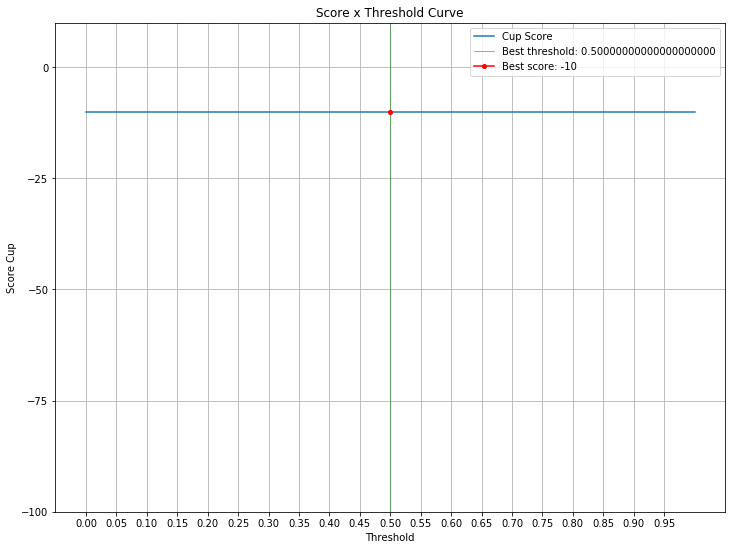

In [7]:
clf1 = ModelDMC(RandomForestClassifier(n_estimators= 500, criterion='entropy', random_state=42),
                train1, test1, resample=False)
yprob1 = clf1.get_output_prob()
clf2 = ModelDMC(RandomForestClassifier(n_estimators= 500, criterion='entropy', random_state=42),
                train2, test2, resample=False)
yprob2 = clf2.get_output_prob()
clf3 = ModelDMC(RandomForestClassifier(n_estimators= 500, criterion='entropy', random_state=42), 
                train3, test3, resample=False)
yprob3 = clf3.get_output_prob()

y_prob = get_full_array(yprob1, yprob2, yprob3)
y_test = get_full_array(test1['fraud'],test2['fraud'],test3['fraud'])
plot_curve(y_test, y_prob, 0.5, fixo=True, ylim=(-100, 10))

### RandomForest - 0.5 Threshold
#### OverSampling SMOTE

In [8]:
clf1 = ModelDMC(RandomForestClassifier(n_estimators= 500, criterion='entropy', random_state=42), train1, test1, resample=True)
yprob1 = clf1.get_output_prob()
clf2 = ModelDMC(RandomForestClassifier(n_estimators= 500, criterion='entropy', random_state=42), train2, test2, resample=True)
yprob2 = clf2.get_output_prob()
clf3 = ModelDMC(RandomForestClassifier(n_estimators= 500, criterion='entropy', random_state=42), train3, test3, resample=True)
yprob3 = clf3.get_output_prob()

y_prob = get_full_array(yprob1, yprob2, yprob3)
y_test = get_full_array(test1['fraud'],test2['fraud'],test3['fraud'])
plot_curve(y_test, y_prob, 0.5, fixo=True, ylim=(-380, -100))

### RandomForest - 0.5 Threshold
#### Tomek

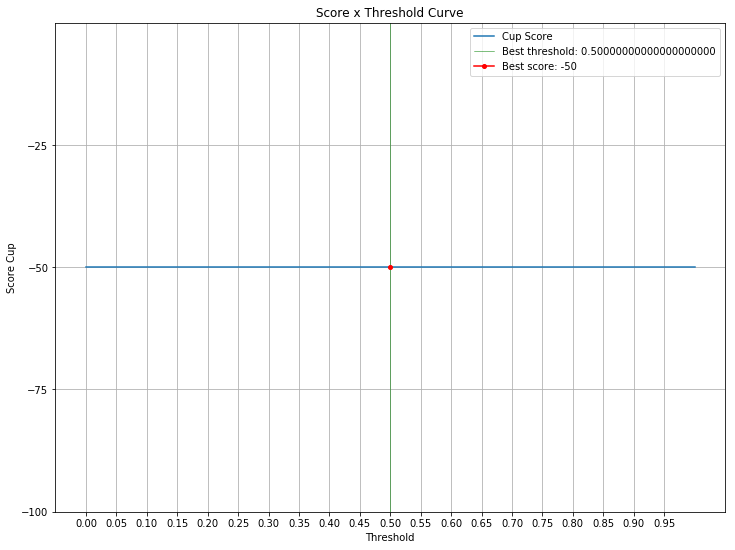

In [9]:
clf1 = ModelDMC(RandomForestClassifier(n_estimators= 500, criterion='entropy', random_state=42), train1, test1, resample=True, res_mode='tomek')
yprob1 = clf1.get_output_prob()
clf2 = ModelDMC(RandomForestClassifier(n_estimators= 500, criterion='entropy', random_state=42), train2, test2, resample=True, res_mode='tomek')
yprob2 = clf2.get_output_prob()
clf3 = ModelDMC(RandomForestClassifier(n_estimators= 500, criterion='entropy', random_state=42), train3, test3, resample=True, res_mode='tomek')
yprob3 = clf3.get_output_prob()

y_prob = get_full_array(yprob1, yprob2, yprob3)
y_test = get_full_array(test1['fraud'],test2['fraud'],test3['fraud'])
plot_curve(y_test, y_prob, 0.5, fixo=True, ylim=(-100,0))

### RandomForest - 0.5 Threshold
#### Undersampling Random

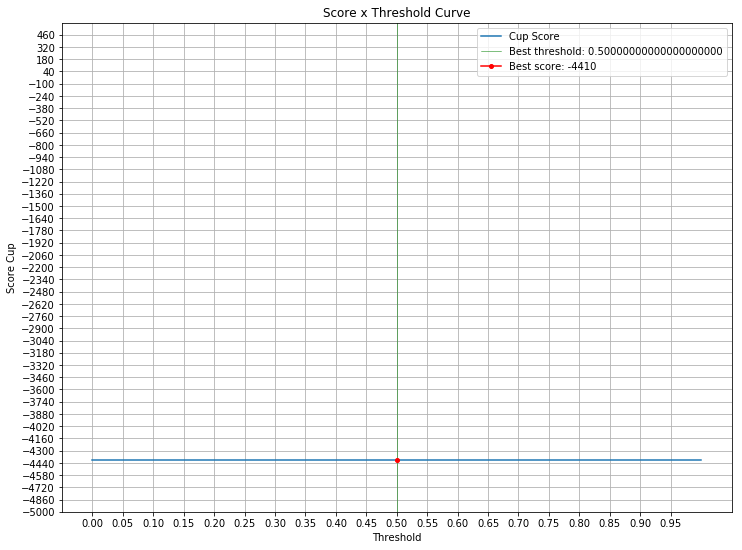

In [10]:
clf1 = ModelDMC(RandomForestClassifier(n_estimators= 500, criterion='entropy', random_state=42), train1, test1, resample=True, res_mode='under')
yprob1 = clf1.get_output_prob()
clf2 = ModelDMC(RandomForestClassifier(n_estimators= 500, criterion='entropy', random_state=42), train2, test2, resample=True, res_mode='under')
yprob2 = clf2.get_output_prob()
clf3 = ModelDMC(RandomForestClassifier(n_estimators= 500, criterion='entropy', random_state=42), train3, test3, resample=True, res_mode='under')
yprob3 = clf3.get_output_prob()

y_prob = get_full_array(yprob1, yprob2, yprob3)
y_test = get_full_array(test1['fraud'],test2['fraud'],test3['fraud'])
plot_curve(y_test, y_prob, 0.5, fixo=True)

### RandomForest - 0.5 Threshold
#### Raiz - Oversampling

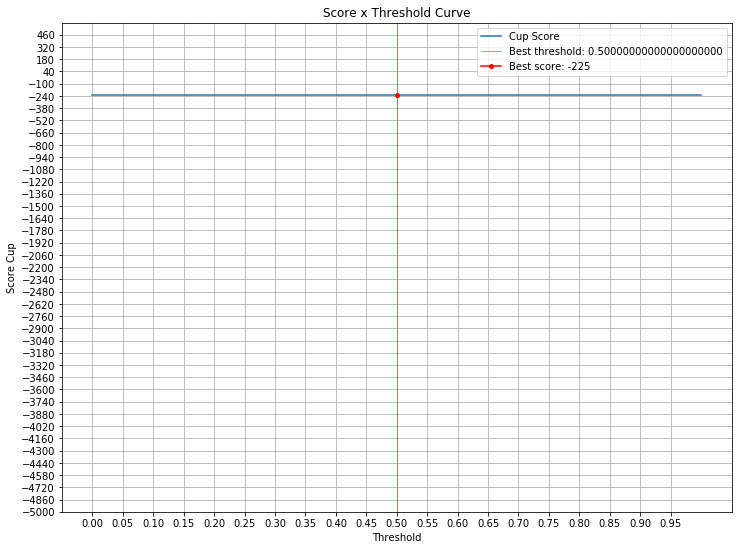

In [11]:
clf1 = ModelDMC(RandomForestClassifier(n_estimators= 500, criterion='entropy', random_state=42), train1, test1, resample=True, res_mode='raiz')
yprob1 = clf1.get_output_prob()
clf2 = ModelDMC(RandomForestClassifier(n_estimators= 500, criterion='entropy', random_state=42), train2, test2, resample=True, res_mode='raiz')
yprob2 = clf2.get_output_prob()
clf3 = ModelDMC(RandomForestClassifier(n_estimators= 500, criterion='entropy', random_state=42), train3, test3, resample=True, res_mode='raiz')
yprob3 = clf3.get_output_prob()

y_prob = get_full_array(yprob1, yprob2, yprob3)
y_test = get_full_array(test1['fraud'],test2['fraud'],test3['fraud'])
plot_curve(y_test, y_prob, 0.5, fixo=True)

### RandomForest - 0.5 Threshold Scaled
#### RobustScaler

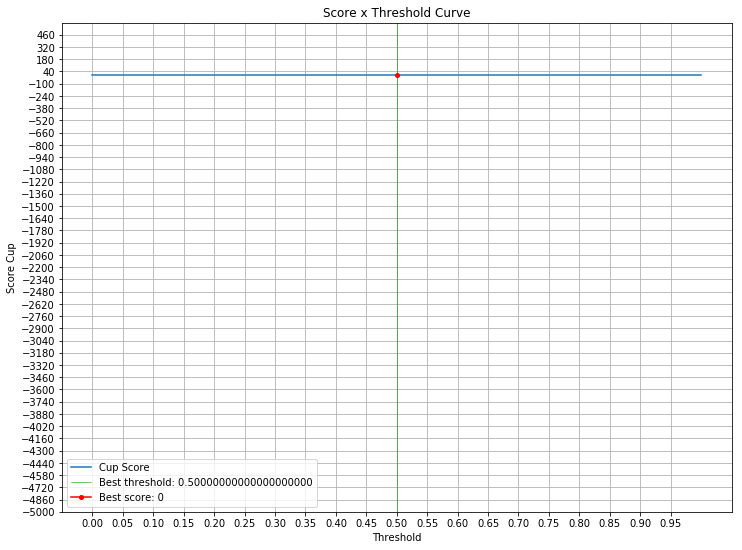

In [12]:
clf1 = ModelDMC(RandomForestClassifier(n_estimators= 500, criterion='entropy', random_state=42), train1, test1, resample=False, norm='robust')
yprob1 = clf1.get_output_prob()
clf2 = ModelDMC(RandomForestClassifier(n_estimators= 500, criterion='entropy', random_state=42), train2, test2, resample=False, norm='robust')
yprob2 = clf2.get_output_prob()
clf3 = ModelDMC(RandomForestClassifier(n_estimators= 500, criterion='entropy', random_state=42), train3, test3, resample=False, norm='robust')
yprob3 = clf3.get_output_prob()

y_prob = get_full_array(yprob1, yprob2, yprob3)
y_test = get_full_array(test1['fraud'],test2['fraud'],test3['fraud'])
plot_curve(y_test, y_prob, 0.5, fixo=True)

### RandomForest - 0.5 Threshold Scaled
#### StandardScaler

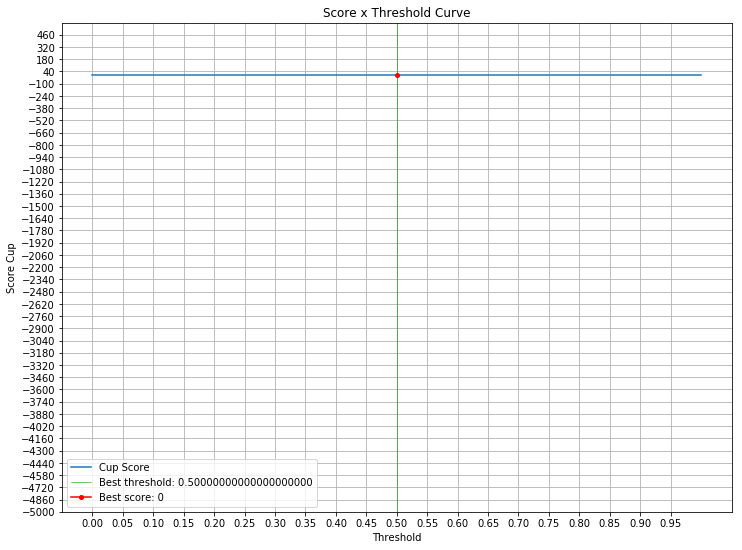

In [13]:
clf1 = ModelDMC(RandomForestClassifier(n_estimators= 500, criterion='entropy', random_state=42), train1, test1, resample=False, norm='stand')
yprob1 = clf1.get_output_prob()
clf2 = ModelDMC(RandomForestClassifier(n_estimators= 500, criterion='entropy', random_state=42), train2, test2, resample=False, norm='stand')
yprob2 = clf2.get_output_prob()
clf3 = ModelDMC(RandomForestClassifier(n_estimators= 500, criterion='entropy', random_state=42), train3, test3, resample=False, norm='stand')
yprob3 = clf3.get_output_prob()

y_prob = get_full_array(yprob1, yprob2, yprob3)
y_test = get_full_array(test1['fraud'],test2['fraud'],test3['fraud'])
plot_curve(y_test, y_prob, 0.5, fixo=True)

## Finding Best Scores

### RandomForest 

#### RandomForest - No resampling

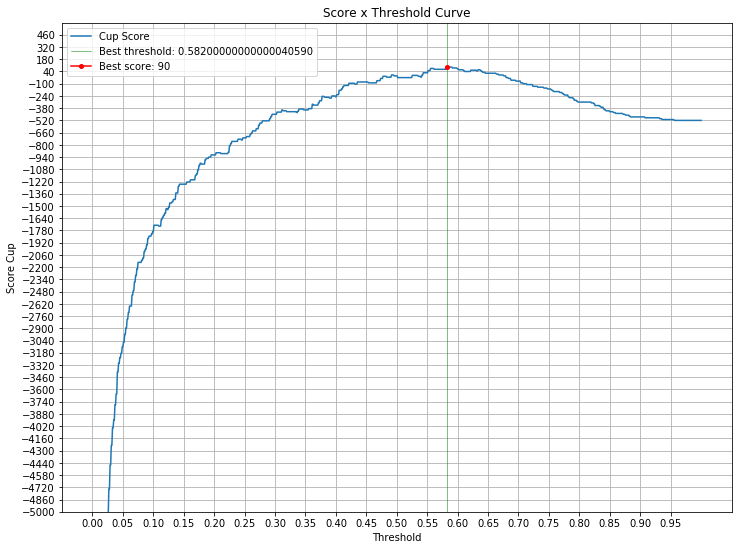

In [14]:
clf1 = ModelDMC(RandomForestClassifier(n_estimators= 500, criterion='entropy', random_state=42),
                train1, test1, resample=False)
yprob1 = clf1.get_output_prob()
clf2 = ModelDMC(RandomForestClassifier(n_estimators= 500, criterion='entropy', random_state=42),
                train2, test2, resample=False)
yprob2 = clf2.get_output_prob()
clf3 = ModelDMC(RandomForestClassifier(n_estimators= 500, criterion='entropy', random_state=42),
                train3, test3, resample=False)
yprob3 = clf3.get_output_prob()

y_prob = get_full_array(yprob1, yprob2, yprob3)
y_test = get_full_array(test1['fraud'],test2['fraud'],test3['fraud'])
plot_curve(y_test, y_prob, 0.001)

In [15]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,(y_prob >= 0.585).astype(int))

array([[1773,    2],
       [  38,   66]])

#### RandomForest - Oversampling - SMOTE

In [16]:
clf1 = ModelDMC(RandomForestClassifier(n_estimators= 500, criterion='entropy', random_state=42),
                train1, test1, resample=True, res_mode='smote')
yprob1 = clf1.get_output_prob()
clf2 = ModelDMC(RandomForestClassifier(n_estimators= 500, criterion='entropy', random_state=42),
                train2, test2, resample=True, res_mode='smote' )
yprob2 = clf2.get_output_prob()
clf3 = ModelDMC(RandomForestClassifier(n_estimators= 500, criterion='entropy', random_state=42),
                train3, test3, resample=True, res_mode='smote' )
yprob3 = clf3.get_output_prob()

y_prob = get_full_array(yprob1, yprob2, yprob3)
y_test = get_full_array(test1['fraud'],test2['fraud'],test3['fraud'])
plot_curve(y_test, y_prob, 0.001)

In [17]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,(y_prob >= 0.707).astype(int))

array([[1762,   13],
       [  38,   66]])

 #### RandomForest - Undersampling - Tomek Links

In [18]:
clf1 = ModelDMC(RandomForestClassifier(n_estimators= 500, criterion='entropy', random_state=42),
                train1, test1, resample=True, res_mode='tomek')
yprob1 = clf1.get_output_prob()
clf2 = ModelDMC(RandomForestClassifier(n_estimators= 500, criterion='entropy', random_state=42),
                train2, test2, resample=True, res_mode='tomek')
yprob2 = clf2.get_output_prob()
clf3 = ModelDMC(RandomForestClassifier(n_estimators= 500, criterion='entropy', random_state=42),
                train3, test3, resample=True, res_mode='tomek')
yprob3 = clf3.get_output_prob()

y_prob = get_full_array(yprob1, yprob2, yprob3)
y_test = get_full_array(test1['fraud'],test2['fraud'],test3['fraud'])
plot_curve(y_test, y_prob, 0.001)

In [19]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,(y_prob >= 0.549).astype(int))

array([[1771,    4],
       [  36,   68]])

 #### RandomForest - Oversampling - Raiz

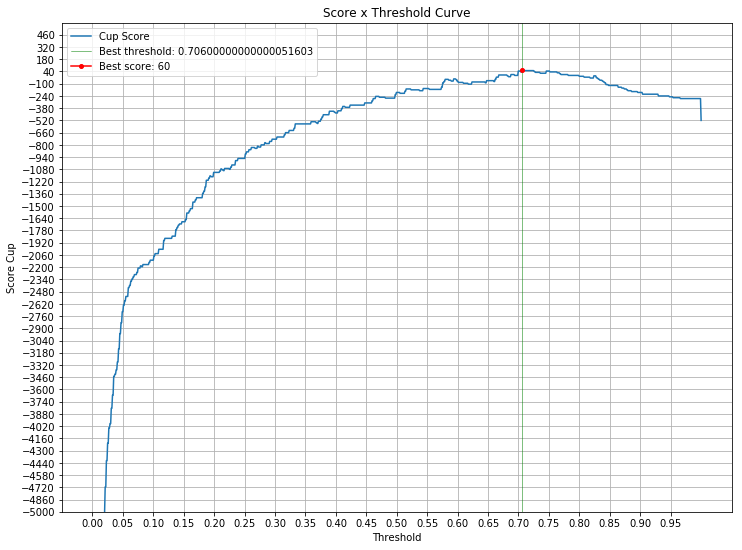

In [20]:
clf1 = ModelDMC(RandomForestClassifier(n_estimators= 500, criterion='entropy', random_state=42),
                train1, test1, resample=True, res_mode='raiz')
yprob1 = clf1.get_output_prob()
clf2 = ModelDMC(RandomForestClassifier(n_estimators= 500, criterion='entropy', random_state=42),
                train2, test2, resample=True, res_mode='raiz')
yprob2 = clf2.get_output_prob()
clf3 = ModelDMC(RandomForestClassifier(n_estimators= 500, criterion='entropy', random_state=42),
                train3, test3, resample=True, res_mode='raiz')
yprob3 = clf3.get_output_prob()

y_prob = get_full_array(yprob1, yprob2, yprob3)
y_test = get_full_array(test1['fraud'],test2['fraud'],test3['fraud'])
plot_curve(y_test, y_prob, 0.001)

#### RandomForest - RobustScaler

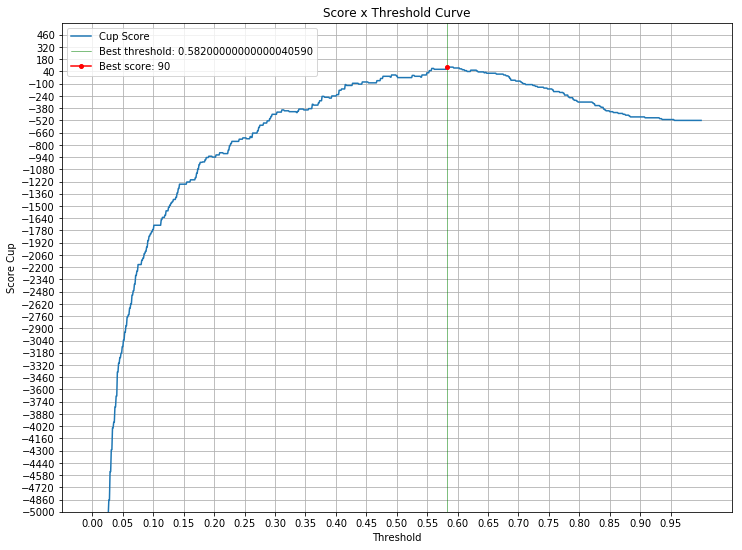

In [21]:
clf1 = ModelDMC(RandomForestClassifier(n_estimators= 500, criterion='entropy', random_state=42),
                train1, test1, resample=False, norm='robust')
yprob1 = clf1.get_output_prob()
clf2 = ModelDMC(RandomForestClassifier(n_estimators= 500, criterion='entropy', random_state=42),
                train2, test2, resample=False, norm='robust')
yprob2 = clf2.get_output_prob()
clf3 = ModelDMC(RandomForestClassifier(n_estimators= 500, criterion='entropy', random_state=42),
                train3, test3, resample=False, norm='robust')
yprob3 = clf3.get_output_prob()

y_prob = get_full_array(yprob1, yprob2, yprob3)
y_test = get_full_array(test1['fraud'],test2['fraud'],test3['fraud'])
plot_curve(y_test, y_prob, 0.001, fixo=False)

In [22]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,(y_prob >= 0.583).astype(int))

array([[1773,    2],
       [  38,   66]])

#### RandomForest - StandardScaler

In [23]:
clf1 = ModelDMC(RandomForestClassifier(n_estimators= 500, criterion='entropy', random_state=42),
                train1, test1, resample=False, norm='stand')
yprob1 = clf1.get_output_prob()
clf2 = ModelDMC(RandomForestClassifier(n_estimators= 500, criterion='entropy', random_state=42),
                train2, test2, resample=False, norm='stand')
yprob2 = clf2.get_output_prob()
clf3 = ModelDMC(RandomForestClassifier(n_estimators= 500, criterion='entropy', random_state=42),
                train3, test3, resample=False, norm='stand')
yprob3 = clf3.get_output_prob()

y_prob = get_full_array(yprob1, yprob2, yprob3)
y_test = get_full_array(test1['fraud'],test2['fraud'],test3['fraud'])
plot_curve(y_test, y_prob, 0.001, fixo=False)

In [24]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,(y_prob >= 0.585).astype(int))

array([[1773,    2],
       [  38,   66]])

### LogisticRegression 

#### LogisticRegression - No resampling

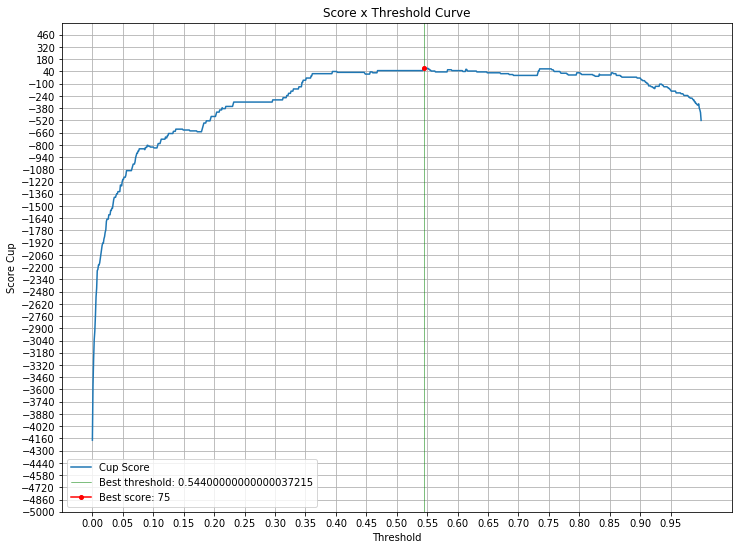

In [25]:
from sklearn.linear_model import LogisticRegression
clf1 = ModelDMC(LogisticRegression(C=25, random_state=42, penalty='l1'), train1, test1, resample=False)
yprob1 = clf1.get_output_prob()
clf2 = ModelDMC(LogisticRegression(C=25,random_state=42, penalty='l1'), train2, test2, resample=False)
yprob2 = clf2.get_output_prob()
clf3 = ModelDMC(LogisticRegression(C=25, random_state=42, penalty='l1'), train3, test3, resample=False)
yprob3 = clf3.get_output_prob()

y_prob = get_full_array(yprob1, yprob2, yprob3)
y_test = get_full_array(test1['fraud'],test2['fraud'],test3['fraud'])
plot_curve(y_test, y_prob, 0.001)

In [26]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,(y_prob >= 0.5441).astype(int))

array([[1764,   11],
       [  17,   87]])

### XGBoost

In [27]:
from xgboost import XGBClassifier

Defining the xGBoost Classifier params found with optimization methods (BayeasianOptimization, optuna and ml-parameter-optimization)

In [72]:
# First set of params found with BayesianOptimization
params ={}
params['bayes_0'] = {'booster':'dart',
                     'max_depth':20, 'gamma':0.2, 
    # Additional parameters for Dart Booster (booster=dart)
    'sample_type': 'uniform',
    'normalize_type': 'forest',
    'rate_drop': 0.1,
    'one_drop': 0,
    'skip_drop': 0.5,
    'lambda': 1,

    'objective':'binary:logistic',

    # AUC_PR of 92.41%+ in optimization with cv, n_estimators = 281
    'eta': 0.38299118824273026,
    'subsample': 0.35,
    'n_estimators': 281,
                     
    # AUC_PR of 91.68%+ in optimization with cv, n_estimators = 281
#     'eta': 0.4,
#     'subsample': 0.35,
    # AUC_PR of 91%+ in optimization with cv, n_estimators = 730
#     'eta': 0.14912839736856998,
#     'subsample': 0.39395166898239,
    # Score of 20+ in optimization with cv, n_estimators = 192
#     'eta': 0.19039735882944445,
#     'subsample': 0.39279757672456206,
    # Score of 20+ in optimization with cv, n_estimators = 268
#     'eta': 0.374510074002978, 
#     'subsample': 0.3901119166914734,
#     'n_estimators': 268,
    # Score of 3+ in optimization with cv, n_estimators = 268
#     'eta': 0.3911561658175267,
#     'subsample': 0.384356938675242,

    'min_child_weight':1, 'max_delta_step':0,
    'colsample_bytree':1, 'colsample_bylevel':1, 'colsample_bynode':1, 
    'seed':0,
    
}

# Second set of params found with BayesianOptimization
best_dart = [{'target': 0.9072546666666667, 
  'params': {'eta': 0.46223494459233166, 'num_boost_round': 249, 'subsample': 0.5}}, 
 {'target': 0.908811, 
  'params': {'eta': 0.15763138515098732, 'num_boost_round': 730, 'subsample': 0.38472861117518387}}, 
 {'target': 0.9099266666666667, 
  'params': {'eta': 0.1674104263181474, 'num_boost_round': 134, 'subsample': 0.46319416536789104}}, 
 {'target': 0.9102796666666668, 
  'params': {'eta': 0.42449710984691236, 'num_boost_round': 193, 'subsample': 0.5}}, 
 {'target': 0.9121146666666666, 
  'params': {'eta': 0.14335843863615289, 'num_boost_round': 134, 'subsample': 0.5}}, 
 {'target': 0.9126083333333334, 
  'params': {'eta': 0.14912839736856998, 'num_boost_round': 730, 'subsample': 0.39395166898239}}, 
 {'target': 0.9162983333333333, 
  'params': {'eta': 0.3690610937345273, 'num_boost_round': 281, 'subsample': 0.34999587130860893}}, 
 {'target': 0.9167740000000001, 
  'params': {'eta': 0.4, 'num_boost_round': 281, 'subsample': 0.35}},
 {'target': 0.9240173333333334, 
  'params': {'eta': 0.38299118824273026, 'num_boost_round': 281, 'subsample': 0.35}}]

best_params = best_dart[-1]['params']
eta = best_params['eta']
num_boost_round = best_params['num_boost_round']
subsample = best_params['subsample']

params['bayes_1'] = {'booster': 'dart', 
          # General Parameters
         'silent': 1,
         'verbosity': 1,
         'nthread': 7,
          'n_jobs': 7,
         'disable_default_eval_metric': 0, # Flag to disable default metric. Set to >0 to disable.

         # Parameters for Tree Booster
         'eta': eta, # alias learning_rate 
         'learning_rate': 0.1,
         'gamma': 0.2, # alias min_split_loss
         'max_depth': int(20),
         'min_child_weight': 1,
         'max_delta_step': 0,
         'subsample': subsample,
         'colsample_bytree': 1.0,
         'colsample_bylevel': 1.0,
         'colsample_bynode': 1.0,
         'lambda': 1,
         'alpha': 0,
         'tree_method': 'auto',
         'scale_pos_weight': 1,
         'updater': 'grow_colmaker,prune',
         'refresh_leaf': 1,
         'process_type': 'default',
         'grow_policy': 'depthwise',

         # Additional parameters for Dart Booster (booster=dart)
         'sample_type': 'uniform',
         'normalize_type': 'forest',
         'rate_drop': 0.1,
         'one_drop': 0,
         'skip_drop': 0.5,


         'objective': 'binary:logistic',
         'base_score': 0.5,
         # User can add multiple evaluation metrics. 
         # Python users: remember to pass the metrics in as list of 
         # parameters pairs instead of map, so that latter eval_metric won't override previous one
         'eval_metric':'aucpr', 
         'seed': 0,
         'n_estimators': num_boost_round
    } 

# Params found with optuna
params['optuna_0'] = {'booster': 'dart',
          # General Parameters
          'silent': 1,
          'verbosity': 1,
          'n_jobs': 7,
          'nthread': 7,
          'disable_default_eval_metric': 0, 
          
          # Parameters for Tree Booster
          'eta': 0.03927151596626287, # alias learning_rate
          'learning_rate': 0.03927151596626287,
#           'eta': 0.1, # alias learning_rate
#           'learning_rate': 0.1,
          'gamma': 2.2736836675238556e-08, # alias min_split_loss
          'max_depth': int(5),
          'min_child_weight': 1,
          'max_delta_step': 0,
#           'subsample': subsample, # not set with this optuna run
          'colsample_bytree': 1.0,
          'colsample_bylevel': 1.0,
          'colsample_bynode': 1.0,
          'lambda': 0.0874178405480134,
          'alpha': 1.0018123081340677e-08, 
          'tree_method': 'auto',
          'scale_pos_weight': 1,
          'updater': 'grow_colmaker,prune',
          'refresh_leaf': 1,
          'process_type': 'default',
          'grow_policy': 'depthwise',
          
          # Additional parameters for Dart Booster (booster=dart)
          'sample_type': 'uniform',
          'normalize_type': 'forest',
          'rate_drop': 0.1292683409244283,
          'skip_drop': 0.3227836972390838,
          
          # Learning Task Parameters
          'objective': 'binary:logistic',
          'base_score': 0.5,
          'eval_metric':'aucpr',
          'seed': 0,
          'n_estimators': 300
         }

# Manual parameters found in XGBClassifier_Inicial
params['manual_0'] = {'booster': 'gbtree',
          'max_depth': 20,
          'min_child_weight':2,
          'eta': 0.01,
          'learning_rate': 0.01,
          'gamma': 0.2,
          'subsample': 0.2,
          'colsample_bytree': 1.0,
          'objective': 'binary:logistic',
          'scale_pos_weight': 1,
          'n_jobs': 7,
          'nthread': 7,
          'eval_metric': 'aucpr',
          'n_estimators': 9001,
          'seed': 27
         }

# Params found with optuna
params['optuna_1']  = {'booster': 'dart',
          # General Parameters
          'silent': 1,
          'verbosity': 1,
          'n_jobs': 7,
          'nthread': 7,
          'disable_default_eval_metric': 0, 
          
          # Parameters for Tree Booster
          'eta': 0.2977459053463421, # alias learning_rate
          'learning_rate': 0.2977459053463421,
#           'eta': 0.1, # alias learning_rate
#           'learning_rate': 0.1,
          'gamma': 8.357269048407964e-05, # alias min_split_loss
          'max_depth': int(8),
          'min_child_weight': 1,
          'max_delta_step': 0,
          'subsample': 0.783454584541423, 
          'colsample_bytree': 1.0,
          'colsample_bylevel': 1.0,
          'colsample_bynode': 1.0,
          'lambda': 1.6501307620966078e-07,
          'alpha': 1.166613432434418e-05, 
          'tree_method': 'auto',
          'scale_pos_weight': 1,
          'updater': 'grow_colmaker,prune',
          'refresh_leaf': 1,
          'process_type': 'default',
          'grow_policy': 'depthwise',
          
          # Additional parameters for Dart Booster (booster=dart)
          'sample_type': 'uniform',
          'normalize_type': 'tree',
          'rate_drop': 0.21270606807102554,
          'skip_drop': 0.18261384324631066,
          
          # Learning Task Parameters
          'objective': 'binary:logistic',
          'base_score': 0.5,
          'eval_metric':'aucpr',
          'seed': 0,
          'n_estimators': 500
         }

# Params found with optuna - F1 Score: 0,86516376451077948
params['optuna_2'] = {'booster': 'dart',
          # General Parameters
          'silent': 1,
          'verbosity': 1,
          'n_jobs': 7,
          'nthread': 7,
          'disable_default_eval_metric': 0, 
          
          # Parameters for Tree Booster
          'eta': 0.02029784466594782, # alias learning_rate
          'learning_rate': 0.02029784466594782,
#           'eta': 0.1, # alias learning_rate
#           'learning_rate': 0.1,
          'gamma': 0.05929591128314911, # alias min_split_loss
          'max_depth': int(7),
          'min_child_weight': 1,
          'max_delta_step': 0,
          'subsample': 0.6069232352712038, 
#           'colsample_bytree': 1.0,
#           'colsample_bylevel': 1.0,
#           'colsample_bynode': 1.0,
          'lambda': 1.0816181698286238e-07,
          'alpha': 0.0114803100927989, 
          'tree_method': 'auto',
          'scale_pos_weight': 1,
          'updater': 'grow_colmaker,prune',
          'refresh_leaf': 1,
          'process_type': 'default',
          'grow_policy': 'lossguide',
          
          # Additional parameters for Dart Booster (booster=dart)
          'sample_type': 'uniform',
          'normalize_type': 'tree',
          'rate_drop': 0.024737388313497213,
          'skip_drop': 0.5279733554274589,
          
          # Learning Task Parameters
          'objective': 'binary:logistic',
          'base_score': 0.5,
          'eval_metric':'aucpr',
#           'seed': 0,
          'n_estimators': 2000
         }

# Params found with optuna - F1 Score: 0,86412526675617995
params['optuna_3'] = {'booster': 'dart',
          # General Parameters
          'silent': 1,
          'verbosity': 1,
          'n_jobs': 7,
          'nthread': 7,
          'disable_default_eval_metric': 0, 
          
          # Parameters for Tree Booster
          'eta': 0.02749540784010372, # alias learning_rate
          'learning_rate': 0.02749540784010372,
#           'eta': 0.1, # alias learning_rate
#           'learning_rate': 0.1,
          'gamma': 5.308831543587659e-05, # alias min_split_loss
          'max_depth': int(7),
          'min_child_weight': 1,
          'max_delta_step': 0,
          'subsample': 0.5583844858310514, 
#           'colsample_bytree': 1.0,
#           'colsample_bylevel': 1.0,
#           'colsample_bynode': 1.0,
          'lambda': 0.0439887573648681,
          'alpha': 0.030270361619614668, 
          'tree_method': 'auto',
          'scale_pos_weight': 1,
          'updater': 'grow_colmaker,prune',
          'refresh_leaf': 1,
          'process_type': 'default',
          'grow_policy': 'lossguide',
          
          # Additional parameters for Dart Booster (booster=dart)
          'sample_type': 'weighted',
          'normalize_type': 'tree',
          'rate_drop': 0.20198326284597928,
          'skip_drop': 0.5007964349474797,
          
          # Learning Task Parameters
          'objective': 'binary:logistic',
          'base_score': 0.5,
          'eval_metric':'aucpr',
#           'seed': 0,
          'n_estimators': 2000
         }
# Params found with bayesian - F1 Score: 0.8635500093127212
params['bayes_2'] = {'booster': 'dart',
          # General Parameters
          'silent': 1,
          'verbosity': 1,
          'n_jobs': 7,
          'nthread': 7,
          'disable_default_eval_metric': 0, 
          
          # Parameters for Tree Booster
          'eta': 0.5, # alias learning_rate
          'learning_rate': 0.5,
          'gamma': 0.5338216424969991, # alias min_split_loss
          'min_split_loss': 0.5338216424969991,
          'max_depth': int(48.47436705164977),
          'min_child_weight': 4.229024744362612,
          'max_delta_step': 80.3964597577857,
          'subsample': 0.9, 
          'colsample_bytree': 1.0,
          'colsample_bylevel': 0.9865649807923106,
          'colsample_bynode': 1.0,
          'lambda': 0.0,
          'alpha': 0.0, 
          'tree_method': 'auto',
          'scale_pos_weight': 1,
          'updater': 'grow_colmaker,prune',
          'refresh_leaf': 1,
          'process_type': 'default',
          'grow_policy': 'depthwise',
          
          # Additional parameters for Dart Booster (booster=dart)
          'sample_type': 'uniform',
          'normalize_type': 'forest',
          'rate_drop': 0.1,
          'one_drop': 0,
          'skip_drop': 0.5,
          
          # Learning Task Parameters
          'objective': 'binary:logistic',
          'base_score': 0.5,
          'eval_metric':'aucpr',
          'seed': 0,
          'n_estimators': 510
         }

# Params found with bayesian - F1 Score: 0.9035663744131878
params['bayes_3'] = {'booster': 'dart',
          # General Parameters
          'silent': 1,
          'verbosity': 1,
          'n_jobs': 7,
          'nthread': 7,
          'disable_default_eval_metric': 0, 
          
          # Parameters for Tree Booster
          'eta': 0.4195320192238707, # alias learning_rate
          'learning_rate': 0.4195320192238707,
          'gamma': 0.6594434998494806, # alias min_split_loss
          'min_split_loss': 0.6594434998494806,
          'max_depth': int(45.19892892494292),
          'min_child_weight': 1.6016252598219185,
          'max_delta_step': 97.95851463554885,
          'subsample': 0.9, 
          'colsample_bytree': 0.978246793827651,
          'colsample_bylevel': 1.0,
          'colsample_bynode': 0.6199685796603064,
          'lambda': 0.011773682500974159,
          'alpha': 0.48538480042807625, 
          'tree_method': 'auto',
          'scale_pos_weight': 1,
          'updater': 'grow_colmaker,prune',
          'refresh_leaf': 1,
          'process_type': 'default',
          'grow_policy': 'depthwise',
          
          # Additional parameters for Dart Booster (booster=dart)
          'sample_type': 'uniform',
          'normalize_type': 'forest',
          'rate_drop': 0.1,
          'one_drop': 0,
          'skip_drop': 0.5,
          
          # Learning Task Parameters
          'objective': 'binary:logistic',
          'base_score': 0.5,
          'eval_metric':'aucpr',
          'seed': 0,
          'n_estimators': 423
         }
# Params found with bayesian - F1 Score: 0.8654744530282098
params['bayes_4'] = {'booster': 'dart',
          # General Parameters
          'silent': 1,
          'verbosity': 0,
          'n_jobs': 7,
          'nthread': 7,
          'disable_default_eval_metric': 0, 
          
          # Parameters for Tree Booster
          'eta': 0.3058923588627213, # alias learning_rate
          'learning_rate': 0.3058923588627213,
          'gamma': 1.0039960961704106, # alias min_split_loss
          'min_split_loss': 0.6594434998494806,
          'max_depth': int(25.029595588074304),
          'min_child_weight': 1.047314340753419,
          'max_delta_step': 99.88690346965778,
          'subsample': 0.6168125387754934, 
          'colsample_bytree': 1.0,
          'colsample_bylevel': 1.0,
          'colsample_bynode': 0.8658913698078194,
          'lambda': 0.018030401719832174,
          'reg_lambda': 0.018030401719832174,
          'alpha': 0.0, 
          'reg_alpha': 0.0, 
          'tree_method': 'auto',
          'scale_pos_weight': 1,
          'updater': 'grow_colmaker,prune',
          'refresh_leaf': 1,
          'process_type': 'default',
          'grow_policy': 'depthwise',
          
          # Additional parameters for Dart Booster (booster=dart)
          'sample_type': 'uniform',
          'normalize_type': 'forest',
          'rate_drop':0.001,
          'one_drop': 0,
          'skip_drop': 1.0,
          
          # Learning Task Parameters
          'objective': 'binary:logistic',
          'base_score': 0.5,
          'eval_metric':'aucpr',
          'seed': 0,
          'random_state': 0,
#           'n_estimators': 2000,
          'num_boost_round': 2000,
         }

Deve ser definido qual o conjunto de parametros vai ser utilizado no XGBoost

Por exemplo, manual_0, bayes_0, bayes_1, optuna_0, optuna_1, optuna_2, optuna_3

```param = params['bayes_0']```


Esses parâmetros foram deteminados pelo bloco anterior.

In [70]:
param = params['bayes_4']

In [74]:
clf1.classifier.get_params

<bound method XGBModel.get_params of XGBClassifier(alpha=0.0, base_score=0.5, booster='dart',
       colsample_bylevel=1.0, colsample_bynode=0.8658913698078194,
       colsample_bytree=1.0, disable_default_eval_metric=0,
       eta=0.3058923588627213, eval_metric='aucpr',
       gamma=1.0039960961704106, grow_policy='depthwise',
       lambda=0.018030401719832174, learning_rate=0.3058923588627213,
       max_delta_step=99.88690346965778, max_depth=25,
       min_child_weight=1.047314340753419,
       min_split_loss=0.6594434998494806, missing=None, n_estimators=2000,
       n_jobs=7, normalize_type='forest', nthread=7, num_boost_round=2000,
       objective='binary:logistic', one_drop=0, process_type='default',
       random_state=0, rate_drop=0.001, refresh_leaf=1, reg_alpha=0.0,
       reg_lambda=0.018030401719832174, sample_type='uniform',
       scale_pos_weight=1, seed=0, silent=1, skip_drop=1.0,
       subsample=0.6168125387754934, tree_method='auto',
       updater='grow_colmake

#### XGBoost - No resampling

Somente do Fold 1



Somente do Fold 2


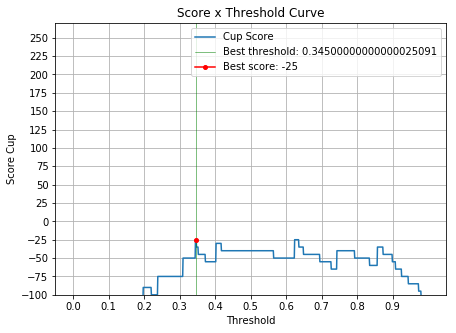


Somente do Fold 3



Agregado


In [73]:
clf1 = ModelDMC(XGBClassifier(**param),
                train1, test1, resample=False)
yprob1 = clf1.get_output_prob()
clf2 = ModelDMC(XGBClassifier(**param),
                train2, test2, resample=False)
yprob2 = clf2.get_output_prob()
clf3 = ModelDMC(XGBClassifier(**param),
                train3, test3, resample=False)
yprob3 = clf3.get_output_prob()

y_prob = get_full_array(yprob1, yprob2, yprob3)
y_test = get_full_array(test1['fraud'],test2['fraud'],test3['fraud'])
# plot_curve(y_test, y_prob, 0.001, ylim=(-100,270))
print('Somente do Fold 1')
plot_curve(test1['fraud'], yprob1, 0.001, ylim=(-100,270),w=7,h=5)
print('\nSomente do Fold 2')
plot_curve(test2['fraud'], yprob2, 0.001, ylim=(-100,270),w=7,h=5)
print('\nSomente do Fold 3')
plot_curve(test3['fraud'], yprob3, 0.001, ylim=(-100,270),w=7,h=5)
print('\nAgregado')
plot_curve(y_test, y_prob, 0.001, ylim=(-100,270),w=10,h=7)

#### XGBoost - Oversampling - Raiz

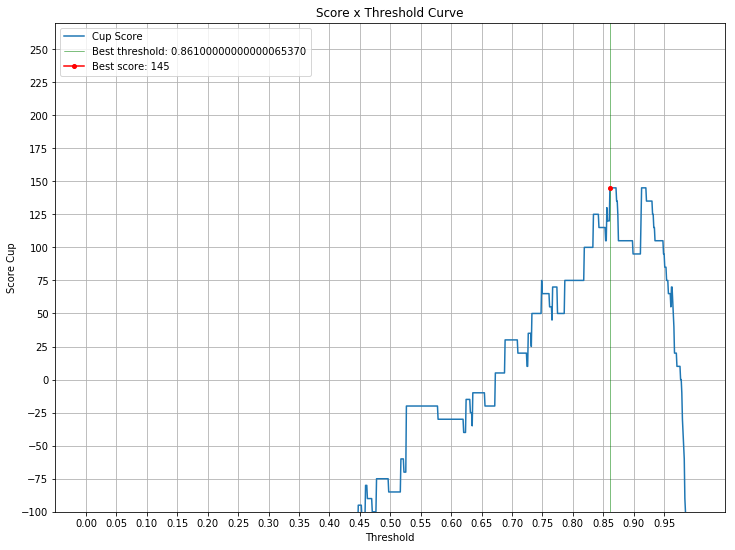

In [50]:
clf1 = ModelDMC(XGBClassifier(**param),
                train1, test1, resample=True, res_mode='raiz')
yprob1 = clf1.get_output_prob()
clf2 = ModelDMC(XGBClassifier(**param),
                train2, test2, resample=True, res_mode='raiz')
yprob2 = clf2.get_output_prob()
clf3 = ModelDMC(XGBClassifier(**param),
                train3, test3, resample=True, res_mode='raiz')
yprob3 = clf3.get_output_prob()

y_prob = get_full_array(yprob1, yprob2, yprob3)
y_test = get_full_array(test1['fraud'],test2['fraud'],test3['fraud'])
plot_curve(y_test, y_prob, 0.001, ylim=(-100,270))

#### XGBoost - RobustScaler

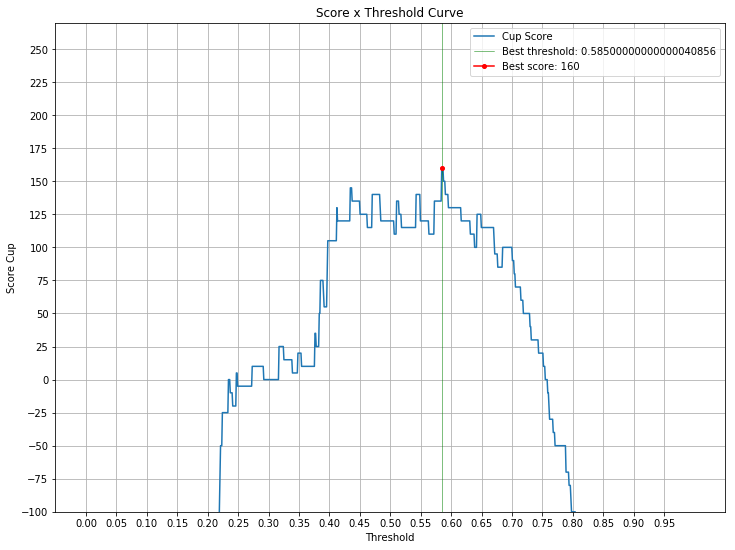

In [51]:
clf1 = ModelDMC(XGBClassifier(**param),
                train1, test1, resample=False, norm='robust')
yprob1 = clf1.get_output_prob()
clf2 = ModelDMC(XGBClassifier(**param),
                train2, test2, resample=False, norm='robust')
yprob2 = clf2.get_output_prob()
clf3 = ModelDMC(XGBClassifier(**param),
                train3, test3, resample=False, norm='robust')
yprob3 = clf3.get_output_prob()

y_prob = get_full_array(yprob1, yprob2, yprob3)
y_test = get_full_array(test1['fraud'],test2['fraud'],test3['fraud'])
plot_curve(y_test, y_prob, 0.001, ylim=(-100,270))

#### XGBoost - Undersampling - Tomek Links

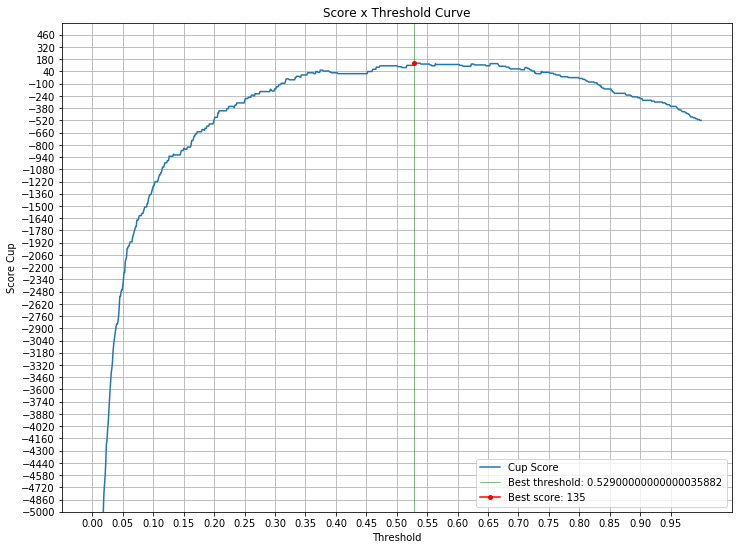

In [52]:
clf1 = ModelDMC(XGBClassifier(**param),
                train1, test1, resample=True, res_mode='tomek')
yprob1 = clf1.get_output_prob()
clf2 = ModelDMC(XGBClassifier(**param),
                train2, test2, resample=True, res_mode='tomek')
yprob2 = clf2.get_output_prob()
clf3 = ModelDMC(XGBClassifier(**param),
                train3, test3, resample=True, res_mode='tomek')
yprob3 = clf3.get_output_prob()

y_prob = get_full_array(yprob1, yprob2, yprob3)
y_test = get_full_array(test1['fraud'],test2['fraud'],test3['fraud'])
plot_curve(y_test, y_prob, 0.001)

In [34]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,(y_prob >= 0.583).astype(int))

array([[1773,    2],
       [  38,   66]])